<a href="https://colab.research.google.com/github/glaria/TFM/blob/main/Colab%20Notebooks/6_TFM_MODELO_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carga del dataset

In [ ]:
from google.colab import drive
import os
import pandas as pd
from sklearn.model_selection import train_test_split

drive.mount('/content/gdrive')

dataset_path = '/content/gdrive/MyDrive/malware_datasets/balanced_df.csv'

df = pd.read_csv(dataset_path)

df = df.drop(['data_source'], axis=1) #quitamos columnas no numericas y las etiquetas


Mounted at /content/gdrive


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_validate
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np
from sklearn.preprocessing import StandardScaler

train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

X = df.drop(['Malware'], axis=1) #quitamos columnas no numericas y las etiquetas
y = df['Malware']

#creamos los conjuntos de train, test y validation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(test_ratio + validation_ratio), random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=(test_ratio / (test_ratio + validation_ratio)), random_state=42)

#reescalamos los datos (util para algunos algoritmos)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)


# Usaremos el mejor random forest que obtuvimos anteriormente

In [ ]:

# modelo random forest
rfc = RandomForestClassifier(n_estimators=300, criterion='gini', min_samples_leaf=1, min_samples_split=2, random_state=42)
rfc.fit(X_train, y_train)

# predecimos los valores del conjunto test
y_pred_rfc = rfc.predict(X_test)

#Calculamos las métricas
accuracy = accuracy_score(y_test, y_pred_rfc)
precision = precision_score(y_test, y_pred_rfc)
recall = recall_score(y_test, y_pred_rfc)
f1 = f1_score(y_test, y_pred_rfc)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Matriz de confusión
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rfc))



Accuracy: 0.9760866052674099
Precision: 0.9748694516971279
Recall: 0.9767822105951602
F1: 0.9758248938255472
Confusion Matrix:
[[3054   77]
 [  71 2987]]


# Y también el mejor modelo de XGBoost obtenido

In [ ]:
#modelo xgboost
xgb_best = XGBClassifier(subsample=1.0, n_estimators=1000, min_child_weight=1, max_depth=9, learning_rate=0.05, gamma=0, colsample_bytree=0.7)
xgb_best.fit(X_train, y_train)

# predecimos los valores del conjunto test
y_pred_xgb = xgb_best.predict(X_test)

#Calculamos las métricas
accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Matriz de confusión
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

Accuracy: 0.9770560672160284
Precision: 0.9733766233766233
Recall: 0.9803793328973185
F1: 0.9768654284783317
Confusion Matrix:
[[3049   82]
 [  60 2998]]


# Construimos el modelo final

In [ ]:
#esta función crea las predicciones de nuestro modelo
def final_prediction(X, rfc_model, xgb_model): #toma como parametros un conjunto X, un modelo random forest ya entrenado y otro modelo xgboost tambien entrenado

    rfc_proba = rfc_model.predict_proba(X)[:, 1]
    xgb_proba = xgb_model.predict_proba(X)[:, 1]

    # definimos los margenes en los que se aplicara cada modelo
    rfc_pred = rfc_proba > 0.5
    xgb_fp_pred = xgb_proba >= 0.75
    xgb_fn_pred = xgb_proba >= 0.1

    # prediccion final
    final_pred = np.where(xgb_fp_pred == xgb_fn_pred, xgb_fp_pred, rfc_pred)

    return final_pred


y_pred = final_prediction(X_test,rfc,xgb_best)

#métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Matriz de confusión
conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: ")
print(conf_mat)

Accuracy: 0.9777023751817742
Precision: 0.9746423927178154
Recall: 0.9803793328973185
F1: 0.9775024453863711
Confusion Matrix: 
[[3053   78]
 [  60 2998]]


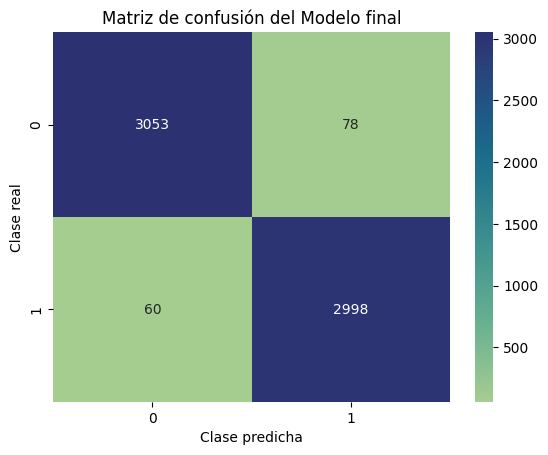

In [ ]:

fig, ax = plt.subplots()
sns.heatmap(conf_mat, annot=True, fmt='d', ax=ax, cmap="crest")

ax.set_title('Matriz de confusión del Modelo final')
ax.set_xlabel('Clase predicha')
ax.set_ylabel('Clase real')

plt.show()

**Este modelo mejora todas las métricas**

#exportamos el modelo

In [ ]:
import pickle

# se guarda el modelo random forest
with open('rfc_model.pkl', 'wb') as f:
    pickle.dump(rfc, f)

# se guarda el modelo XGBoost en un archivo
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_best, f)


In [ ]:
#guardamos también el objeto obtenido con standard scaler
with open('std_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
X_test

array([[-0.01568121, -0.01359928, -0.53847566, ..., -0.09940323,
        -0.19957372,  0.94773061],
       [-0.01568121, -0.01370615, -0.53847566, ..., -0.02104898,
        -0.19957372, -1.04861151],
       [-0.01568121, -0.01370615, -0.53847566, ..., -0.03512232,
        -0.19957372, -1.13041285],
       ...,
       [-0.01568121, -0.01370615,  1.8187686 , ..., -0.0362634 ,
        -0.19957372, -1.10898869],
       [-0.01568121, -0.00750771, -0.53847566, ..., -0.07506016,
        -0.19957372, -1.13041285],
       [-0.01568121, -0.01370615, -0.53847566, ..., -0.10853188,
        -0.19957372,  0.86398163]])

#escalabilidad del modelo

In [ ]:
import timeit

df_bootstrap = df.sample(n=160000, replace=True, random_state=42)
X = df_bootstrap.drop(['Malware'], axis=1) #quitamos columnas no numericas y las etiquetas
y = df_bootstrap['Malware']

train_ratio = 0.5
test_ratio = 0.5

#creamos los conjuntos de train, test y validation
X_train, X_validation, y_train, y_test = train_test_split(X, y, test_size=test_ratio , random_state=42)

#reescalamos los datos (util para algunos algoritmos)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)

#Tamaños de los conjuntos de datos para medir escalabilidad
sizes = [5000, 10000, 20000 ,40000, 80000]

train_times = []
predict_times = []
train_times_std = []
predict_times_std = []

# Número de repeticiones
n_runs = 20

for size in sizes:

    X_train_sub = X_train[:size]
    y_train_sub = y_train[:size]

    train_times_run = []
    predict_times_run = []

    for _ in range(n_runs):
        # Medimos tiempo de entrenamiento
        start_time = timeit.default_timer()
        rfc.fit(X_train_sub, y_train_sub)
        xgb_best.fit(X_train_sub, y_train_sub)
        end_time = timeit.default_timer()
        train_times_run.append(end_time - start_time)

        # Subconjunto del conjunto de validación
        X_validation_sub = X_validation[:size]

        # Medimos tiempo de predicción
        start_time = timeit.default_timer()
        final_prediction(X_validation_sub, rfc, xgb_best)
        end_time = timeit.default_timer()
        predict_times_run.append(end_time - start_time)
        print(f"Ejecutando paso de tamaño: {(size, len(predict_times))}")
    # Añadir la media de los tiempos de ejecución a las listas
    train_times.append(np.mean(train_times_run))
    predict_times.append(np.mean(predict_times_run))
    train_times_std.append(np.std(train_times_run))
    predict_times_std.append(np.std(predict_times_run))




Ejecutando paso de tamaño: (5000, 0)
Ejecutando paso de tamaño: (5000, 0)
Ejecutando paso de tamaño: (5000, 0)
Ejecutando paso de tamaño: (5000, 0)
Ejecutando paso de tamaño: (5000, 0)
Ejecutando paso de tamaño: (5000, 0)
Ejecutando paso de tamaño: (5000, 0)
Ejecutando paso de tamaño: (5000, 0)
Ejecutando paso de tamaño: (5000, 0)
Ejecutando paso de tamaño: (5000, 0)
Ejecutando paso de tamaño: (5000, 0)
Ejecutando paso de tamaño: (5000, 0)
Ejecutando paso de tamaño: (5000, 0)
Ejecutando paso de tamaño: (5000, 0)
Ejecutando paso de tamaño: (5000, 0)
Ejecutando paso de tamaño: (5000, 0)
Ejecutando paso de tamaño: (5000, 0)
Ejecutando paso de tamaño: (5000, 0)
Ejecutando paso de tamaño: (5000, 0)
Ejecutando paso de tamaño: (5000, 0)
Ejecutando paso de tamaño: (10000, 1)
Ejecutando paso de tamaño: (10000, 1)
Ejecutando paso de tamaño: (10000, 1)
Ejecutando paso de tamaño: (10000, 1)
Ejecutando paso de tamaño: (10000, 1)
Ejecutando paso de tamaño: (10000, 1)
Ejecutando paso de tamaño: (1000

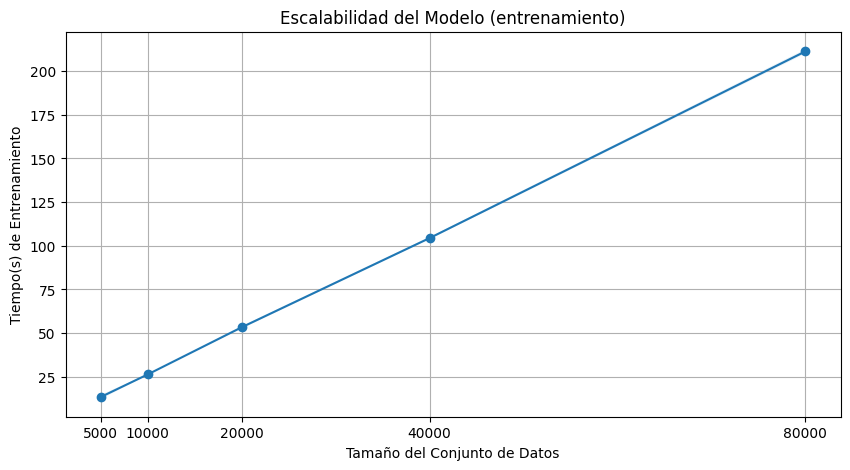

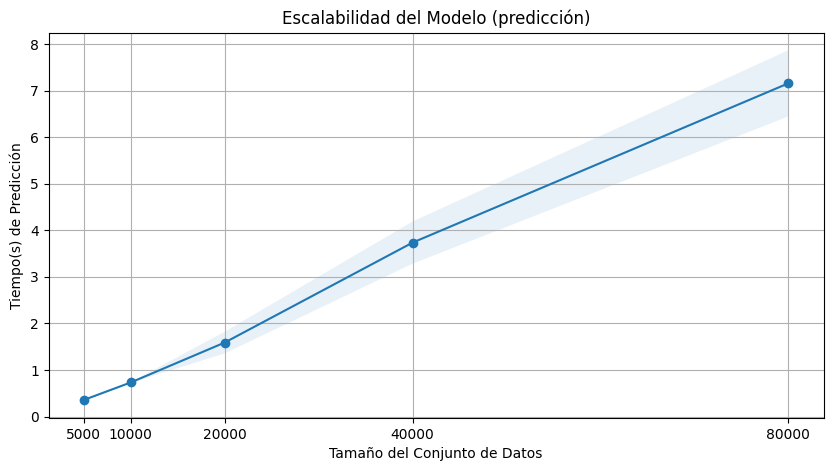

In [ ]:
#tiempos de entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(sizes, train_times, marker='o')
plt.fill_between(sizes, np.array(train_times)-np.array(train_times_std), np.array(train_times)+np.array(train_times_std), alpha=0.1)
plt.title('Escalabilidad del Modelo (entrenamiento)')
plt.xlabel('Tamaño del Conjunto de Datos')
plt.ylabel('Tiempo(s) de Entrenamiento')
plt.grid(True)
plt.xticks(sizes)
plt.show()

#tiempos de predicción
plt.figure(figsize=(10, 5))
plt.plot(sizes, predict_times, marker='o')
plt.fill_between(sizes, np.array(predict_times)-np.array(predict_times_std), np.array(predict_times)+np.array(predict_times_std), alpha=0.1)
plt.title('Escalabilidad del Modelo (predicción)')
plt.xlabel('Tamaño del Conjunto de Datos')
plt.ylabel('Tiempo(s) de Predicción')
plt.grid(True)
plt.xticks(sizes)
plt.show()
